In [1]:
import pennylane, numpy, pandas
print("Imports OK")


Imports OK


In [2]:
from typing import Dict, Any
import pathlib
import numpy as np

def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Stub for constructing or loading the measurement operators you plan to use.
    Populate the return value with operator definitions, normalization checks, and metadata.
    """
    P0 = np.array([[1, 0],
                   [0, 0]], dtype=float)

    P1 = np.array([[0, 0],
                   [0, 1]], dtype=float)

    operators = {
        "Z_0": P0,
        "Z_1": P1
    }
    sum_ops = P0 + P1
    identity = np.eye(2)
    completeness_ok = np.allclose(sum_ops, identity)
    measurement_model = {
        "measurement_type": "Pauli-Z projective",
        "num_qubits": 1,
        "operators": operators,
        "completeness_check": completeness_ok,
        "normalization_note": "Sum of projectors equals identity",
        "source": "Standard Pauli-Z measurement",
        "config_path": str(config_path)
    }

    return measurement_model

In [3]:
model = build_measurement_model(pathlib.Path("config.yaml"))

print("Completeness OK:", model["completeness_check"])
print("Available operators:", model["operators"].keys())


Completeness OK: True
Available operators: dict_keys(['Z_0', 'Z_1'])


In [4]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()
    



In [5]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [6]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

In [7]:
import json
import numpy as np
import pennylane as qml
from collections import Counter
from dataclasses import dataclass
from typing import List
import pathlib



def run_circuit_and_measure(circuit_fn, shots=1000):
    dev = qml.device("default.qubit", wires=1, shots=shots)

    @qml.qnode(dev)
    def measured():
        circuit_fn()
        return qml.sample(qml.PauliZ(0))

    samples = measured()  # shape: (shots,)
    counts = Counter(samples)
    probs = {int(k): v / shots for k, v in counts.items()}

    return counts, probs


def compute_density_matrix(circuit_fn):
    dev = qml.device("default.qubit", wires=1)

    @qml.qnode(dev)
    def state():
        circuit_fn()
        return qml.state()

    psi = state()
    rho = np.outer(psi, np.conj(psi))
    return rho

def get_circuit_by_name(name):
    def circuit():
        if name == "plus":
            qml.Hadamard(wires=0)

        elif name == "minus":
            qml.PauliX(wires=0)
            qml.Hadamard(wires=0)

        elif name == "phase":
            qml.Hadamard(wires=0)
            qml.S(wires=0)

        elif name == "one":
            qml.PauliX(wires=0)

        # else: |0⟩ → do nothing

    return circuit


@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    for variant in variants:
        print(f"\nGenerating dataset for state: {variant.name}")

        circuit_fn = get_circuit_by_name(variant.name)

        counts, probs = run_circuit_and_measure(circuit_fn, shots=1000)
        print("Counts:", counts)
        print("Probabilities:", probs)

        np.save(
            variant.measurement_data_path,
            {
                "counts": dict(counts),
                "probabilities": probs
            }
        )

        rho = compute_density_matrix(circuit_fn)
        np.save(variant.density_matrix_path, rho)

        metadata = {
            "state": variant.name,
            "measurement_model": variant.measurement_model,
            "shots": 1000,
            "circuit_summary": variant.circuit_summary
        }

        with open(variant.metadata_path, "w") as f:
            json.dump(metadata, f, indent=2)

        print("Saved files:")
        print(" ", variant.measurement_data_path)
        print(" ", variant.density_matrix_path)
        print(" ", variant.metadata_path)


variants = [
    DatasetVariant(
        name="plus",
        circuit_summary="H",
        measurement_model="Pauli-Z",
        measurement_data_path=pathlib.Path("single_qubit_plus.npy"),
        metadata_path=pathlib.Path("single_qubit_plus_meta.json"),
        density_matrix_path=pathlib.Path("single_qubit_plus_rho.npy")
    )
]

generate_measurement_dataset(variants)



Generating dataset for state: plus
Counts: Counter({np.float64(1.0): 510, np.float64(-1.0): 490})
Probabilities: {-1: 0.49, 1: 0.51}
Saved files:
  single_qubit_plus.npy
  single_qubit_plus_rho.npy
  single_qubit_plus_meta.json


/opt/miniconda3/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning:

Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.



In [8]:
#your code ..
import numpy as np
import json
import pathlib
import pennylane as qml
from collections import Counter
from scipy.linalg import sqrtm


I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    return np.real(np.trace(inner))**2


def trace_distance(rho, sigma):
    diff = rho - sigma
    eigvals = np.linalg.eigvals(diff)
    return 0.5 * np.sum(np.abs(eigvals))

def reconstruct_density_matrix(expectations):
    return 0.5 * (
        I
        + expectations["X"] * X
        + expectations["Y"] * Y
        + expectations["Z"] * Z
    )

def measure_pauli(circuit_fn, pauli, shots=1000):
    dev = qml.device("default.qubit", wires=1, shots=shots)

    @qml.qnode(dev)
    def circuit():
        circuit_fn()

        # Rotate measurement basis → Z
        if pauli == "X":
            qml.Hadamard(wires=0)
        elif pauli == "Y":
            qml.adjoint(qml.S)(wires=0)
            qml.Hadamard(wires=0)
        elif pauli == "Z":
            pass

        return qml.sample(qml.PauliZ(0))  # ✅ terminal measurement

    samples = circuit()                 # shape: (shots,)
    counts = Counter(samples)

    exp = (counts.get(1, 0) - counts.get(-1, 0)) / shots
    return counts, exp

def state_0(): 
    pass

def state_1(): 
    qml.PauliX(wires=0)

def state_plus(): 
    qml.Hadamard(wires=0)

def state_minus():
    qml.PauliX(wires=0)
    qml.Hadamard(wires=0)

def state_phase():
    qml.Hadamard(wires=0)
    qml.S(wires=0)


states = {
    "0": state_0,
    "1": state_1,
    "+": state_plus,
    "-": state_minus,
    "phase": state_phase
}

def true_density_matrix(circuit_fn):
    dev = qml.device("default.qubit", wires=1)

    @qml.qnode(dev)
    def state():
        circuit_fn()
        return qml.state()

    psi = state()
    return np.outer(psi, np.conj(psi))

base_path = pathlib.Path("data/single_qubit")
base_path.mkdir(parents=True, exist_ok=True)

results = []

for name, circuit_fn in states.items():
    expectations = {}
    raw_counts = {}

    for pauli in ["X", "Y", "Z"]:
        counts, exp = measure_pauli(circuit_fn, pauli)
        expectations[pauli] = exp
        raw_counts[pauli] = dict(counts)

    rho_recon = reconstruct_density_matrix(expectations)
    rho_true = true_density_matrix(circuit_fn)

    fid = fidelity(rho_true, rho_recon)
    td = trace_distance(rho_true, rho_recon)

    # Save files
    np.save(base_path / f"{name}_rho_reconstructed.npy", rho_recon)
    np.save(base_path / f"{name}_rho_true.npy", rho_true)

    with open(base_path / f"{name}_metadata.json", "w") as f:
        json.dump({
            "state": name,
            "expectations": expectations,
            "fidelity": float(fid),
            "trace_distance": float(td),
            "measurement_model": "Pauli XYZ",
            "shots": 1000
        }, f, indent=2)

    results.append((name, fid, td))

for r in results:
    print(f"State {r[0]} | Fidelity: {r[1]:.4f} | Trace distance: {r[2]:.4f}")


State 0 | Fidelity: 1.0000 | Trace distance: 0.0230
State 1 | Fidelity: 1.0000 | Trace distance: 0.0219
State + | Fidelity: 1.0000 | Trace distance: 0.0224
State - | Fidelity: 1.0000 | Trace distance: 0.0072
State phase | Fidelity: 1.0000 | Trace distance: 0.0100


/var/folders/l_/1ys11k5j2gx0hrq2gfnn_z5m0000gn/T/ipykernel_99953/3507268873.py:16: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.

/var/folders/l_/1ys11k5j2gx0hrq2gfnn_z5m0000gn/T/ipykernel_99953/3507268873.py:17: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.



In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
from pathlib import Path


def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    records = []

    for path in result_paths:
        # Expect JSON metadata files
        with open(path, "r") as f:
            meta = json.load(f)

        records.append({
            "State": meta.get("state"),
            "Fidelity": meta.get("fidelity"),
            "Trace Distance": meta.get("trace_distance"),
            "Shots": meta.get("shots"),
            "Measurement Model": meta.get("measurement_model")
        })

    # Convert to table
    df = pd.DataFrame(records)

    print("\nValidation Summary Table:")
    print(df)

    # Simple plots (optional but recommended)
    plt.figure()
    plt.bar(df["State"], df["Fidelity"])
    plt.ylabel("Fidelity")
    plt.title("Reconstruction Fidelity by State")
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.bar(df["State"], df["Trace Distance"])
    plt.ylabel("Trace Distance")
    plt.title("Trace Distance by State")
    plt.show()



Validation Summary Table:
   State  Fidelity  Trace Distance  Shots Measurement Model
0      0       1.0        0.023022   1000         Pauli XYZ
1      +       1.0        0.022361   1000         Pauli XYZ
2      -       1.0        0.007211   1000         Pauli XYZ
3  phase       1.0        0.010000   1000         Pauli XYZ
4      1       1.0        0.021932   1000         Pauli XYZ


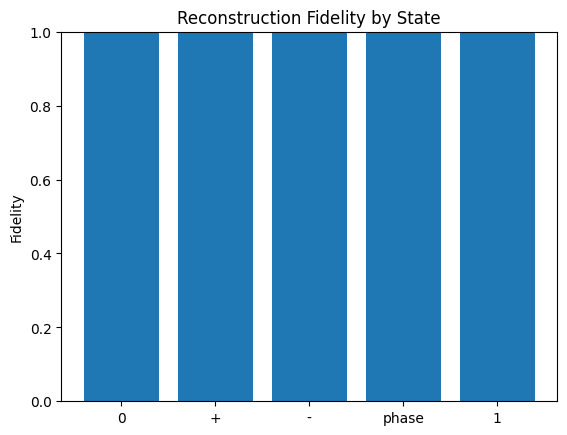

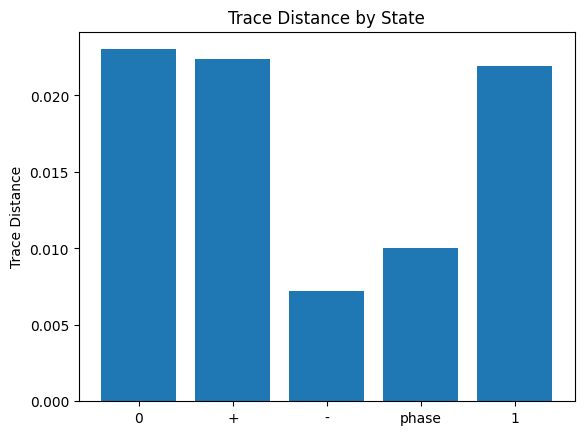

In [10]:
from pathlib import Path

result_paths = list(Path("data/single_qubit").glob("*_metadata.json"))
summarize_validation_runs(result_paths)
